# Two decades of "We didn't start the fire"

Twenty years ago this month, Billy Joel released *We Didn't Start the Fire*. Which (and I'm paraphrasing the wikipedia article[https://en.wikipedia.org/wiki/We_Didn't_Start_the_Fire]) he wrote to convice a 21 year old that a lot of stuff had happened over the course of Joel's life. 

But can he convince a computer?

For those of you who have never listened to a classic rock station, *We Didn't Start the Fire*, poses an interesting challenge from the perspective of Natural Language Processing, because it is mostly a list of people, places, events and even a few things which effected popular culture, global politics, and domestic (to the US) politics.

Here are the lyrics, which I lovingly copy and pasted from a, frankly, sketchy lyrics website.

In [20]:
lyrics = """
Harry Truman, Doris Day, Red China, Johnnie Ray
South Pacific, Walter Winchell, Joe DiMaggio
Joe McCarthy, Richard Nixon, Studebaker, television
North Korea, South Korea, Marilyn Monroe

Rosenbergs, H-bomb, Sugar Ray, Panmunjom
Brando, "The King and I" and "The Catcher in the Rye"
Eisenhower, vaccine, England's got a new queen
Marciano, Liberace, Santayana goodbye

We didn't start the fire
It was always burning since the world's been turning
We didn't start the fire
No we didn't light it but we tried to fight it

Joseph Stalin, Malenkov, Nasser and Prokofiev
Rockefeller, Campanella, Communist Bloc
Roy Cohn, Juan Peron, Toscanini, dacron
Dien Bien Phu falls, "Rock Around the Clock"
Einstein, James Dean, Brooklyn's got a winning team
Davy Crockett, Peter Pan, Elvis Presley, Disneyland

Bardot, Budapest, Alabama, Krushchev
Princess Grace, "Peyton Place", trouble in the Suez
We didn't start the fire
It was always burning since the world's been turning

We didn't start the fire
No we didn't light it but we tried to fight it
Little Rock, Pasternak, Mickey Mantle, Kerouac
Sputnik, Chou En-Lai, "Bridge on the River Kwai"
Lebanon, Charlse de Gaulle, California baseball
Starkweather homicide, children of thalidomide

Buddy Holly, "Ben Hur", space monkey, Mafia
Hula hoops, Castro, Edsel is a no-go
U-2, Syngman Rhee, payola and Kennedy
Chubby Checker, "Psycho", Belgians in the Congo
""".replace("\n",", ")

The first step we want to take is to tokenize the lyrics. But this itselfe poses a some trouble. Most NLP books/tutorials start with part of speech tagging. This prepares a text so that a computer can understand the grammar text.

This is a super interesting topic, but it is not a whole lot of use here, as even by the standards of poetry, Mr. Joel has largely forgone grammar. In stead, we wish to understand what sort of people, places, events, and things that Joel decided to fuel this irrestistably catchy karaoke white whale.

In NLP, we call people, places, events, and other things *Named Entities*, and the type of taggin we would want to use for this sort of thing is...

## Named Entity Recognition

I am going to load in Spacy packages which I selected mostly becasuse it is the only package I am familiar with for Named Entity Recognition :)

In [26]:
import pandas as pd
import spacy
from spacy import displacy
from spacy.tokens import Span
from collections import Counter

The first thing we are going to do is load out *corpus* of named entites as `sp`.

In [15]:
sp = spacy.load('en_core_web_lg')

Now, we an apply this corpus to the lyrics, which will tokenize into entities (well, the `ents` attribute).

In [21]:
sen = sp(lyrics)

A spacy Entity object has text and label set as attributes `text` and `label_` respectively. Further you can get a description, of a label by calling the `explain` function in the `spacy` package. To make these a little easier to work with I am going to unload these into a dataframe.

In [18]:
ents_df.head()

,Entity,Type,Description
0,Harry Truman,PERSON,"People, including fictional"
1,Doris Day,PERSON,"People, including fictional"
2,Red China,ORG,"Companies, agencies, institutions, etc."
3,Johnnie Ray,PERSON,"People, including fictional"
4,South Pacific,GPE,"Countries, cities, states"


But wait, let's look at the number of entities there are.

In [7]:
len(sen.ents)

72

Hold on! Wikipedia said there were "over 100" things referenced! A whopping 2.25 things for every year of Billy Joel's life!  But this is only 72 entities, or a measly 1.8 things.

Let's use a function `displacy` to try to figure out what we've missed. 

In [23]:
displacy.render(sen, jupyter = True, style = "ent")

Here we come to the reason why this is a good example of why NLP is challenging. This song is supposed to be a barage of emotionally charged memes that, when taken as a whole, forms story of nostalgic accomplishments. But when we look at individual pieces, it can seem muddled and silly. But I suppose most nostalgia looks silly from the outside.

The question which I have struggled with when thinking about how to tag this is the extent to which the entities that Joel cites are stand ins for events. In one sense, this gives the song it's *ripped from the evening news* feel -- in particular using locations as short hand for specific events is something that I strongly associate with television news. This is, if anything, where the emotional intelligence of the song comes from, from the fact that Joel was able to find the short words and phrases which will send people, from a certain culture and generation, into daydreams of a moments or whole eras of their lives.

And this is the problem we face. Single words can mean many different things, does *Nixon* refer to the person, does it refer to the various political campaigns? Does it refer to his Scandals and Retirements. And these are all things that we make decisions about every time we turn on the TV or read the newspaper (okay, fine... or look at Facebook/Twitter). Some of these meanings can be gleaned from texts, but others are meta-textual. For example, the wikipedia article asserts that Joel's reference to Nixon refers to his first presidential campaigne because it comes along with other things from the 50s and 60s. Meaning that if Nixon was referenced in the second stanza, it may have been construed as a reference to his resignation!

(I personally don't think that the call to Nixon refers to a single event, but rather to the whole career, and there are plenty of cases where the time-line is not match stanzas. But again, these lyrics are better understood by the feelings the entities evoke, and less the reason why they cause these emotions.)

I seem to have forgotten to do a tutorial. So let's fill in missed, and mislabeled tags:

First, we create a Dataframe that will act as a dictionary of words to their locations. I do not know if Spacy has this functionality, but I could only find how to add entities from their position in the document. (If I'm wrong, let me know!)

In [94]:
word_positions = pd.DataFrame({"words":[str(x) for x in list(sen.doc)], "position":range(len(sen.doc))})

word_positions = word_positions.set_index("words")

Now we shall create a loop which will label certain things as `products`, `works` of art, and in one special case, a `person` :)

The syntax for `Span` is that you need the tagged document, the start and end locations of the entity.

In [100]:
from spacy.tokens import Span

products = ["television", "H", "vaccine", "dacron","thalidomide"]

words = []

for product in products:
    word_start = word_positions.loc[product]
    word_end = word_start + 1
    words.append(Span(sen, word_start, word_end,
                      label = sp.vocab.strings["PRODUCT"]))

works = [("Bridge", "Kwai"),  ("Psycho", "Psycho")]

for work in works:
    word_start, word_end = (word_positions.loc[x] for x in work)
    word_end += 1
    words.append(Span(sen, word_start, word_end, label = sp.vocab.strings["WORK_OF_ART"]))

words.append(Span(sen, word_positions.loc["space"], word_positions.loc["monkey"]+1,
                 label = sp.vocab.strings["PERSON"]))
sen.ents = list (sen.ents) + words

Let's finally take a look at how the tags look now.

In [101]:
displacy.render(sen, jupyter = True, style = "ent")

This is a little sloppy, I haven't fixed all the tags to include all of the words in each tag, but this will work for some simple analysis.

There is also a lot of debating as to what should be tagged as what. As per my earlier discussion, I did not include any events, since it could be argued (and kind of is by the wikipedia page) that most if not all of the entities are short hand for events.

I know, it might be weird to classify an H-bomb as a product, but I'm not sure where else it would fit in the scheme. I also toyed with the idea of making `Disneyland` a geo-political entity.

Finally, Let's take a look at the the distribution of the different types of tags and their prominence in the lyrics.

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

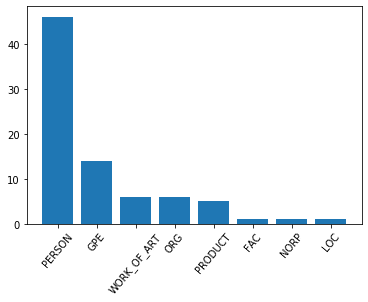

In [105]:
import matplotlib.pyplot as plt

ents_df = pd.DataFrame(
{"Entity" : [x.text for x in sen.ents],
 "Type" : [x.label_ for x in sen.ents],
 "Description" : [str(spacy.explain(x.label_)) for x in sen.ents]}
)

counts = ents_df.Type.value_counts()

plt.bar(counts.index, counts)
plt.xticks(rotation=50)

It isn't too surprising that there are mostly people and geo-political entities making up the vast majority of the references of the song. These are the things which the news uses most often to stand in for the events of the day, and world leaders and important organizations are involved in multiple events, making them an economical way of delivering the most emotional bang for your buck.